In [1]:
#@title Importing libraries (double-click to show code)
import os
import pkg_resources
pkg_resources.require("numpy>=`1.20.1")  #  to use specific numpy version
import numpy as np
import rsnapsim as rss
import sys
from sys import platform
from skimage import io ; from skimage.io import imread; from skimage.measure import find_contours
from random import randrange
import pandas as pd
import os; from os import listdir; from os.path import isfile, join
import re
import shutil
import pathlib
from pathlib import Path
from random import randrange
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout 
from IPython.display import Image
import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord
import tqdm.notebook as tq

# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = False


In [2]:
# Plasmid sequences
gene_file_pUB_SM_KDM5B_PP7 = str(sequences_dir.joinpath('pUB_SM_KDM5B_PP7.gb')) # plasmid pUB_SM_KDM5B_PP7 
gene_file_pUB_SM_p300_MS2 = str(sequences_dir.joinpath('pUB_SM_p300_MS2.gb')) # plasmid pUB_SM_p300_MS2

# Coding sequence
gene_file_KDM5B_PP7 = str(sequences_dir.joinpath('pUB_SM_KDM5B_PP7_coding_sequence.txt')) # coding sequence for SM_KDM5B_PP7    ### 5685 nt   ### 1895 codons
gene_file_p300_MS2 = str(sequences_dir.joinpath('pUB_SM_p300_MS2_coding_sequence.txt'))  # coding sequence for SM_p300_MS2      ### 8268 nt   ### 2756 codons

In [3]:
from dna_features_viewer import BiopythonTranslator
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator
    """
    def compute_feature_color(self, feature):
        if feature.type == "CDS":
            return "#57B956"
        elif feature.type == "FLAG":
            return "#57B956"
        elif feature.type == "MS2":
            return "#098BF5"
        elif feature.type == "PP7": 
            return "#EB5559"
        else:
            return "#C4B07B"

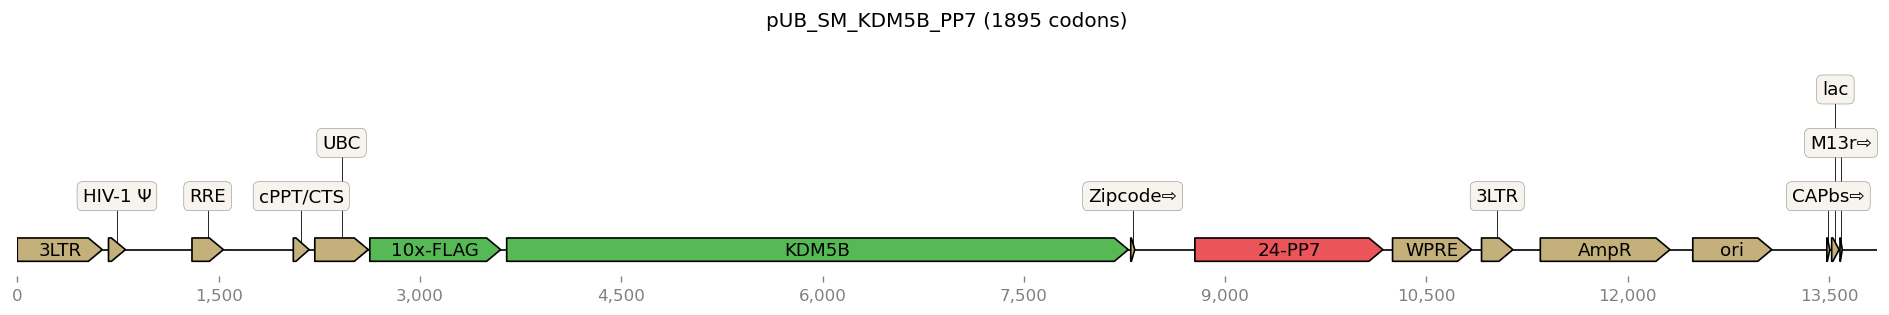

In [4]:
graphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_KDM5B_PP7) 
ax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)
ax.set_title('pUB_SM_KDM5B_PP7 (1895 codons)')
graphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)
#ax.figure.savefig("pUB_SM_KDM5B_PP7.png")

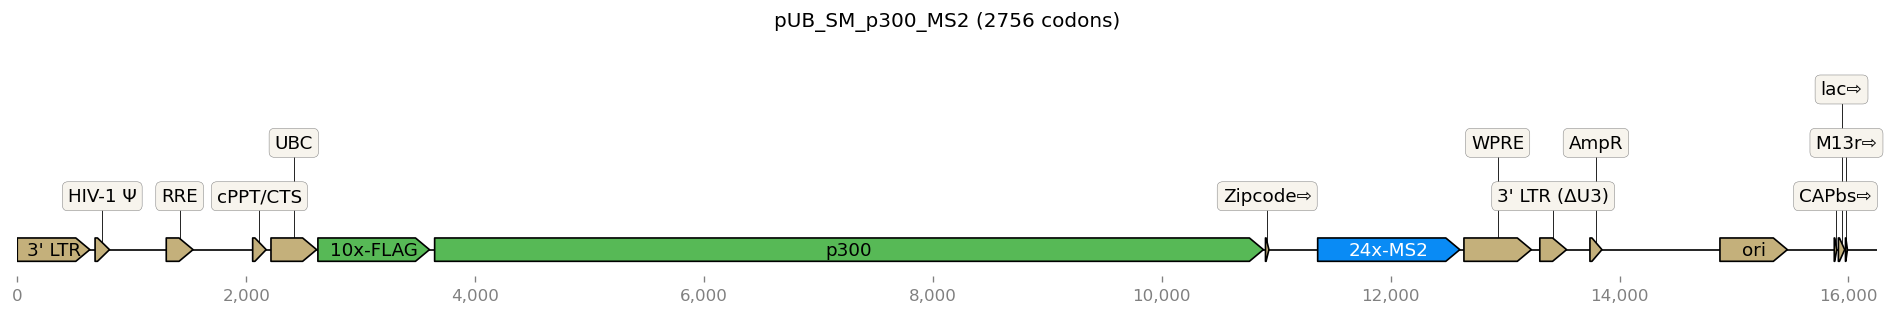

In [5]:
graphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_p300_MS2) 
ax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)
ax.set_title('pUB_SM_p300_MS2 (2756 codons)')
graphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)
#ax.figure.savefig("pUB_SM_p300_MS2.png")

In [6]:
# Reading all empty cells in directory
list_files_names = sorted([f for f in listdir(video_dir) if isfile(join(video_dir, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
num_cell_shapes = len(path_files)

In [7]:
# Constant Parameters
list_gene_sequences = [gene_file_KDM5B_PP7, gene_file_p300_MS2] # path to gene sequences
list_label_names = ['kdm5b','p300'] # list of strings used to generate a classification field in the output data frame
step_size_in_sec = 1 # step size
save_as_tif = 0 # option to save the simulated video
save_dataframe = 0 # option to save the simulation output as a dataframe in format csv. 
create_temp_folder = 0 # saves the video and data frame in a temp folder
spot_size = 5 # size of spots in pixels
list_number_spots = [25, 25] # list of integers, where each element represents the number of spots
number_cells = 5 # Number of simulated Cell
list_target_channels_proteins = [1, 1] # channel where the simulated protein spots will be located. Integer between 0 and 2. 
list_target_channels_mRNA = [0, 2] # channel where the simulated mRNA spots will be located. Integer between 0 and 2. 
simulation_time_in_sec = 300

In [8]:
# Parameters that affect the simulation dynamics.
#frame_selection_empty_video = 'constant' # Options are: 'constant' , 'shuffle' and 'loop'
#list_diffusion_coefficients =[0.55, 0.55] # diffusion coefficients for each gene
#list_elongation_rates = [10, 10] # elongation rates aa/sec
#list_initiation_rates = [0.03, 0.03] # initiation rates 1/sec

In [9]:
intensity_scale_ch0 = 60
intensity_scale_ch1 = 60
intensity_scale_ch2 = 60

In [10]:
# Path to store data
multiplexing_path_folder = Path('/','home','luisub','Dropbox','multiplexing')   # Dropbox Linux
#multiplexing_path_folder = Path('/','Users','luisaguilera','Dropbox','multiplexing')  # Dropbox Mac
#multiplexing_path_folder = Path('/','Users','luisaguilera','Desktop','testing')

In [11]:
def simulate_multiplexing(tested_list_elongation_rates,tested_list_initiation_rates,tested_list_diffusion_coefficients,multiplexing_path_folder):
    # function  that simulates the multiplexing experiments    
    list_dataframe_simulated_cell =[]
    list_ssa_all_cells_and_genes =[]
    for i in tq.tqdm(range(0,number_cells)): # for i in range (0,number_cells ):
        saved_file_name = 'cell_' + str(i)  # if the video or dataframe are save, this variable assigns the name to the files
        sel_shape = randrange(num_cell_shapes)
        video_path = path_files[sel_shape]
        initial_video = io.imread(video_path) # video with empty cell

        # This step reduces the intensity of the empty video by a half. This is necessary to match the intensity in a video with spots. Check code "Analysis_simulated_cells.ipynb"
        initial_video = initial_video//2
        _, single_dataframe_simulated_cell, list_ssa = rsp.SimulatedCellMultiplexing(initial_video,list_gene_sequences,list_number_spots,list_target_channels_proteins,list_target_channels_mRNA, tested_list_diffusion_coefficients,list_label_names,tested_list_elongation_rates,tested_list_initiation_rates,simulation_time_in_sec,step_size_in_sec,save_as_tif, save_dataframe, saved_file_name,create_temp_folder,cell_number =i,frame_selection_empty_video=frame_selection_empty_video,spot_size =spot_size ,intensity_scale_ch0 = intensity_scale_ch0,intensity_scale_ch1 = intensity_scale_ch1,intensity_scale_ch2 = intensity_scale_ch2).make_simulation()
        list_dataframe_simulated_cell.append(single_dataframe_simulated_cell)
        list_ssa_all_cells_and_genes.append(list_ssa)
    # Creating a folder
    folder_to_save_data = 'multiplexing_data__bg_' + frame_selection_empty_video + '__ke_' + str(tested_list_elongation_rates[0])+'_'+str(tested_list_elongation_rates[1])+'__ki_'+str(tested_list_initiation_rates[0])[2:]+'_'+str(tested_list_initiation_rates[1])[2:]+'__kdiff_'+str(tested_list_diffusion_coefficients[0])+'_'+str(tested_list_diffusion_coefficients[1])  + '__time_' + str(simulation_time_in_sec) + '__cells_' + str(number_cells) +'__spots_' +str(list_number_spots[0])+ '_' +str(list_number_spots[1]) +'__int_scale_' +str(intensity_scale_ch0)
    folder_to_save_data = folder_to_save_data.replace(".", "_")
    multiplexing_path = multiplexing_path_folder.joinpath(folder_to_save_data)
    dataframe_simulated_cell = pd.concat(list_dataframe_simulated_cell)
    ssas_multiplexing = np.array(list_ssa_all_cells_and_genes)
    return multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing

In [12]:
def save_data (multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing):
    security_testing = multiplexing_path.parents[0].exists()
    # tesging if the parent path exis
    if security_testing == True:
        if not multiplexing_path.exists():
            #multiplexing_path.mkdir()
            os.makedirs(multiplexing_path)
        else:
            shutil.rmtree(multiplexing_path)
            #multiplexing_path.mkdir()
            os.makedirs(multiplexing_path)
        # saving the dataframe
        dataframe_simulated_cell.to_csv( multiplexing_path.joinpath('multiplexing_csv.csv'))
        # saving the ssa
        np.save(multiplexing_path.joinpath('ssas_multiplexing.npy') , ssas_multiplexing)
        # creating zip
        shutil.make_archive(multiplexing_path, 'zip', multiplexing_path.parents[0],folder_to_save_data)
        shutil.rmtree(multiplexing_path)
    else:
        print ('The folder doesnt exist')

In [13]:
frame_selection_empty_video = 'constant' # Options are: 'constant' , 'shuffle' and 'loop'
# Simulation_0
list_diffusion_coefficients =[0.55, 0.55] # diffusion coefficients for each gene
list_elongation_rates = [10, 10] # elongation rates aa/sec
list_initiation_rates = [0.03, 0.03] # initiation rates 1/sec
multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing = simulate_multiplexing(list_elongation_rates,list_initiation_rates,list_diffusion_coefficients,multiplexing_path_folder)
save_data (multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing)
#del multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
dataframe_simulated_cell

In [ ]:
raise

In [ ]:
frame_selection_empty_video = 'shuffle' # Options are: 'constant' , 'shuffle' and 'loop'
# Simulation_1
list_diffusion_coefficients =[0.55, 0.55] # diffusion coefficients for each gene
list_elongation_rates = [10, 10] # elongation rates aa/sec
list_initiation_rates = [0.03, 0.03] # initiation rates 1/sec
multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing = simulate_multiplexing(list_elongation_rates,list_initiation_rates,list_diffusion_coefficients,multiplexing_path_folder)
save_data (multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing)
del multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing

In [ ]:
raise

In [ ]:
# Simulation_2
list_diffusion_coefficients =[0.5, 0.5] # diffusion coefficients for each gene
list_elongation_rates = [10, 10] # elongation rates aa/sec
list_initiation_rates = [0.05, 0.03] # initiation rates 1/sec
multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing = simulate_multiplexing(list_elongation_rates,list_initiation_rates,list_diffusion_coefficients,multiplexing_path_folder)
save_data (multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing)
multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing

In [ ]:
# Simulation_3
list_diffusion_coefficients =[0.9, 0.2] # diffusion coefficients for each gene
list_elongation_rates = [10, 10] # elongation rates aa/sec
list_initiation_rates = [0.03, 0.03] # initiation rates 1/sec
multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing = simulate_multiplexing(list_elongation_rates,list_initiation_rates,list_diffusion_coefficients,multiplexing_path_folder)
save_data (multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing)
multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing